In [ ]:
#!pip install annoy

In [42]:
from collections import defaultdict, Counter
import numpy as np
import string
import pandas as pd
import re
import os
import torch
from argparse import Namespace
import tqdm
import torch
import torch.nn as nn
from tqdm import tqdm
from annoy import AnnoyIndex
from tqdm import notebook
import torch.nn.functional as F
import json
import seaborn as sns
import matplotlib.pyplot as plt

## 설정값 지정

In [14]:
args = Namespace(
    # 데이터 정보
    raw_train_dataset_csv="data/train.csv",
    raw_test_dataset_csv="data/test_for_inference.csv",
    proportion_subset_of_train=0.1,
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    comment_csv='data/comments.csv',
    # 날짜와 경로 정보
    frequency_cutoff=25,
    model_state_file='model.pth',
    save_dir='model_storage/',
    vectorizer_file='vectorizer.json',
    # 훈련 하이퍼파라미터
    batch_size=512,
    early_stopping_criteria=5,
    learning_rate=0.001,
    num_epochs=50,
    max_seq_length=200,
    seed=1337,
    # 실행 옵션
    cuda=True,
    expand_filepaths_to_save_dir=True,
)

# 데이터로드 및 정제, 훈련/검증/테스트 세트 , EDA

## 데이터 로드

In [5]:
train_comments = pd.read_csv(args.raw_train_dataset_csv)
train_comments.head()

,comment,toxicity
0,I am testing. ) 207.97.213.169,0
1,honestly ==\nyou need to crawl under a rock an...,1
2,""":The Russian idiom """"to let the he-goat into ...",0
3,"""\nCreated and dominated\n[Hamilton] created a...",0
4,This one and this one. 24.177.120.138,0


## 훈련, 검증, 테스트 세트 만들기

In [28]:
# Toxicity 기준으로 데이터를 나누어 클래스 비율을 유지하도록 합니다.
by_comment = defaultdict(list)
for _, row in train_comments.iterrows():
    by_comment[row.toxicity].append(row.to_dict())

In [29]:
# 훈련, 검증, 테스트 분할 데이터를 만듭니다.
final_list = []
np.random.seed(args.seed)

for _, item_list in sorted(by_comment.items()):
    np.random.shuffle(item_list)
    n_total = len(item_list)
    n_train = int(args.train_proportion * n_total)
    n_val = int(args.val_proportion * n_total)
    n_test = int(args.test_proportion * n_total)

    for item in item_list[:n_train]:
        item['split'] = 'train'

    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'

    for item in item_list[n_train+n_val:]:
        item['split'] = 'test'

    final_list.extend(item_list)

final_comments = pd.DataFrame(final_list)

## 데이터 정제

In [30]:
def preprocess_text(text):
    text = re.sub(r"[^0-9a-zA-Z ]", "", text).lower()
    text = text.strip()
    text = re.sub(' +', ' ', text)
    return text

final_comments.comment = final_comments.comment.apply(preprocess_text)
final_comments['toxicity'] = final_comments.toxicity.apply({0: 'nottoxic', 1: 'toxic'}.get)
final_comments.to_csv(args.comment_csv, index=False)

In [31]:
final_comments

,comment,toxicity,split
0,indent reset please do while these look good s...,nottoxic,train
1,i would like to known about pointer in java la...,nottoxic,train
2,copyright problemshello concerning your contri...,nottoxic,train
3,elbing disambig any objections to redirecting ...,nottoxic,train
4,help why am i blocked help help help one more ...,nottoxic,train
...,...,...,...
79780,niggerballs why did you delete the page you as...,toxic,test
79781,youre very foolish you know that right if you ...,toxic,test
79782,awwwwww doesnt poor little femto like getting ...,toxic,test
79783,wikitheclownwelcome to wikipedia although ever...,toxic,test


## 정돈된 Data불러오고 EDA

In [32]:
df = pd.read_csv(args.comment_csv)

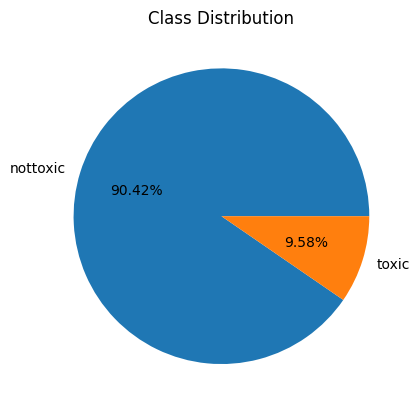

In [33]:
# Class 분포 확인
import seaborn as sns
import matplotlib.pyplot as plt
plt.pie(df["toxicity"].value_counts(), labels=['nottoxic','toxic'], autopct='%1.2f%%')
plt.title('Class Distribution')
plt.show()

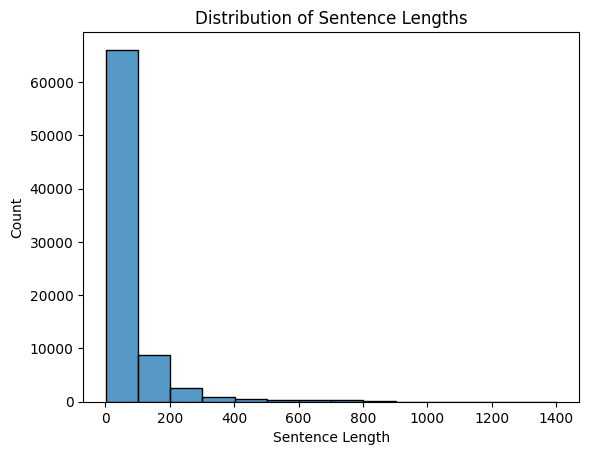

In [59]:

sentence_lengths = df['comment'].apply(lambda x: len(x.split()))


sns.histplot(data=sentence_lengths, binwidth=100)

plt.xlabel('Sentence Length')
plt.ylabel('Count')
plt.title('Distribution of Sentence Lengths')

plt.show()

# Traning을 위한 Class: `CommentDataset`, `Vocabulary`, `PreTrainedEmbedding`, `EmbeddingVectorizer`

### `CommentDataset`

In [15]:
from torch.utils.data import Dataset

class CommentDataset(Dataset):
    def __init__(self, comment_df, vectorizer):

        self.comment_df = comment_df
        self._vectorizer = vectorizer


        self._max_seq_length = args.max_seq_length  # Sequence 최대 길이

        self.train_df = self.comment_df[self.comment_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.comment_df[self.comment_df.split=='val']
        self.val_size = len(self.val_df)

        self.test_df= self.comment_df[self.comment_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.val_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train') # train, test, val 결정

    @classmethod
    def load_dataset_and_make_vectorizer(cls, comment_csv):
        comment_df = pd.read_csv(comment_csv)
        train_comment_df = comment_df[comment_df.split=='train']
        return cls(comment_df, CommentEmbeddingVectorizer.from_dataframe(train_comment_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, comment_csv, vectorizer_filepath):
        comment_df = pd.read_csv(comment_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(comment_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return CommentEmbeddingVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):

        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):

        return self._target_size

    def __getitem__(self, index):

        row = self._target_df.iloc[index]

        comment_vector, vec_length = self._vectorizer.vectorize(row.comment, self._max_seq_length)

        toxicity_index = self._vectorizer.toxicity_vocab.lookup_token(row.toxicity)

        return {'x_data': comment_vector,
               'y_target': toxicity_index,
                'x_length': vec_length}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

### `Vocabulary`
-> rf.실제로는 Class Vocab만 사용됨.

In [16]:
class Vocabulary(object):

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token
                             for token, idx in self._token_to_idx.items()}

        self._add_unk = add_unk
        self._unk_token = unk_token

        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token)


    def to_serializable(self):

        return {'token_to_idx': self._token_to_idx,
                'add_unk': self._add_unk,
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):

        return cls(**contents)

    def add_token(self, token):

        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token

        return index

    def lookup_token(self, token):

        if self.unk_index >=0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):

        if index not in self._idx_to_token:
            raise KeyError("Vocabulary에 인덱스(%d)가 없습니다." % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

### `PreTrainedEmbedding`

In [8]:
class PreTrainedEmbeddings(object):
    """ 사전 훈련된 단어 벡터 사용을 위한 래퍼 클래스 """
    def __init__(self, word_to_index, word_vectors):

        self.word_to_index = word_to_index
        self.word_vectors = word_vectors
        self.index_to_word = {v: k for k, v in self.word_to_index.items()}

        self.index = AnnoyIndex(len(word_vectors[0]), metric='euclidean')
        print("인덱스 만드는 중!")
        for _, i in self.word_to_index.items():
            self.index.add_item(i, self.word_vectors[i])
        self.index.build(50)
        print("완료!")

    @classmethod
    def from_embeddings_file(cls, embedding_file):

        word_to_index = {}
        word_vectors = []

        special_tokens = ["<START>", "<END>", "<UNK>", "<MASK>"]
        for token in special_tokens:
            word_to_index[token] = len(word_to_index)
            word_vectors.append(np.random.randn(100)) # 100 standsfor embedding dimension

        with open(embedding_file) as fp:
            for line in fp.readlines():
                line = line.split(" ")
                word = line[0]
                vec = np.array([float(x) for x in line[1:]])

                word_to_index[word] = len(word_to_index)
                word_vectors.append(vec)

        return cls(word_to_index, word_vectors)

    def get_embedding(self, word):

        return self.word_vectors[self.word_to_index.get(word, self.word_to_index['<UNK>'])] #!! Changed


### `EmbeddingVectorizer`

In [17]:
class CommentEmbeddingVectorizer(object):
    def __init__(self, comment_vocab, toxicity_vocab, vocab_embeddings=PreTrainedEmbeddings.from_embeddings_file('data/glove/glove.6B.100d.txt')):

        self.comment_vocab = comment_vocab
        self.toxicity_vocab = toxicity_vocab
        self.vocab_embeddings = vocab_embeddings

    def vectorize(self, comment, vector_length=-1):
        tokens = comment.split(" ")

        embed_vec = np.zeros((vector_length, 100), dtype=np.float32)
        embed_vec[0] = self.vocab_embeddings.get_embedding("<START>")

        idx = 1

        if len(tokens) < (vector_length -2):
          for token in tokens:
            embed_vec[idx] = self.vocab_embeddings.get_embedding(token)
            idx += 1
          embed_vec[idx] = self.vocab_embeddings.get_embedding("<END>")
          embed_vec[idx+1:] = self.vocab_embeddings.get_embedding("<MASK>")
          return embed_vec, idx+1
        else:
          for token in tokens:

            embed_vec[idx] = self.vocab_embeddings.get_embedding(token)
            idx += 1
            if idx == (vector_length -1):
              embed_vec[idx] = self.vocab_embeddings.get_embedding("<END>")
              break
          return embed_vec, vector_length


    @classmethod
    def from_dataframe(cls, comment_df, cutoff=25):

        comment_vocab = Vocabulary(add_unk=True)
        toxicity_vocab = Vocabulary(add_unk=False)

        for toxicity in sorted(set(comment_df.toxicity)):
            toxicity_vocab.add_token(toxicity)

        word_counts = Counter()
        for comment in comment_df.comment:
            for word in comment.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1

        for word, count in word_counts.items():
            if count > cutoff:
                comment_vocab.add_token(word)

        return cls(comment_vocab, toxicity_vocab)

    @classmethod
    def from_serializable(cls, contents):

        continueomment_vocab = Vocabulary.from_serializable(contents['comment_vocab'])
        toxicity_vocab =  Vocabulary.from_serializable(contents['toxicity_vocab'])

        return cls(comment_vocab=comment_vocab, toxicity_vocab=toxicity_vocab)

    def to_serializable(self):

        return {'comment_vocab': self.comment_vocab.to_serializable(),
                'toxicity_vocab': self.comment_vocab.to_serializable()}

인덱스 만드는 중!
완료!


### `DataLoader`

In [18]:
from torch.utils.data import DataLoader

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                           shuffle=shuffle, drop_last=drop_last)
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

### `Text 분류기`

In [19]:
def column_gather(y_out, x_lengths):

    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
      out.append(y_out[batch_index, column_index])

    return torch.stack(out)

In [20]:
class ToxicCommentClassifier(nn.Module):

    def __init__(self, embedding_size, rnn_hidden_size, batch_first=True):

        super(ToxicCommentClassifier, self).__init__()
        self.rnn1 = nn.GRU(input_size=embedding_size,
                            hidden_size=rnn_hidden_size,
                            batch_first=batch_first)
        self.rnn2 = nn.GRU(input_size=embedding_size,
                            hidden_size=rnn_hidden_size,
                            batch_first=batch_first)
        self.fc1 = nn.Linear(in_features=rnn_hidden_size*2,
                             out_features=rnn_hidden_size*2)
        self.fc2 = nn.Linear(in_features=rnn_hidden_size*2,
                             out_features = rnn_hidden_size)
        self.fc3 = nn.Linear(in_features=rnn_hidden_size,
                             out_features=1)

    def forward(self, x_in, x_lengths=None, apply_sigmoid=False):

        x_in_inverse = x_in.clone()
        for i in range(x_in.size(0)):
          indices_to_reverse = torch.arange(x_lengths[i] - 1, -1, -1)
          x_in_inverse[i, :x_lengths[i], :] = x_in_inverse[i, indices_to_reverse, :]

        y_out_1, _ = self.rnn1(x_in)
        if x_lengths is not None:
          y_out_1 = column_gather(y_out_1, x_lengths)
        else:
          y_out_1 = y_out_1[:, -1, :]

        y_out_2, _ = self.rnn2(x_in_inverse)
        if x_lengths is not None:
          y_out_2 = column_gather(y_out_2, x_lengths)
        else:
          y_out_2 = y_out_2[:, -1, :]

        y_out = torch.cat((y_out_1, y_out_2), dim=1)

        y_out = F.relu(self.fc1(F.dropout(y_out, 0.5)))
        y_out = F.relu(self.fc2(F.dropout(y_out, 0.5)))
        y_out = self.fc3(F.dropout(y_out, 0.5)).squeeze()
        if apply_sigmoid:
            y_out = torch.sigmoid(y_out)
        return y_out

## 설정

In [21]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)

set_seed_everywhere(args.seed, args.cuda)

handle_dirs(args.save_dir)

### 헬퍼 함수

In [22]:
import torch.optim as optim

def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):

    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False


    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        if loss_t >= train_state['early_stopping_best_val']:
            train_state['early_stopping_step'] += 1

        else:
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
            train_state['early_stopping_step'] = 0
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state


def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long()
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100


def compute_f1(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred) > 0.5).cpu().long()

    tp = torch.sum((y_pred_indices == 1) & (y_target == 1)).item()
    fp = torch.sum((y_pred_indices == 1) & (y_target == 0)).item()
    fn = torch.sum((y_pred_indices == 0) & (y_target == 1)).item()

    precision = tp / max((tp + fp), 1e-8)
    recall = tp / max((tp + fn), 1e-8)
    f1 = 2 * (precision * recall) / max((precision + recall), 1e-8)

    return f1 * 100

def compute_tpr(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred) > 0.5).cpu().long()

    tp = torch.sum((y_pred_indices == 1) & (y_target == 1)).item()
    fn = torch.sum((y_pred_indices == 0) & (y_target == 1)).item()

    tpr = tp / max((tp + fn), 1e-8)

    return tpr * 100


## 데이터셋, 모델, 손실, 옵티마이저, 훈련 상태 딕셔너리 만들기

In [31]:
if not torch.cuda.is_available():
  args.cuda=False

args.device = torch.device("cuda" if args.cuda else "cpu")

dataset = CommentDataset.load_dataset_and_make_vectorizer(args.comment_csv)
dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.get_vectorizer()

classifier = ToxicCommentClassifier(embedding_size=100, rnn_hidden_size=64)
classifier = classifier.to(args.device)

loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)
train_state = make_train_state(args)

## 훈련 반복

In [ ]:
epoch_bar = notebook.tqdm(desc='training routine',
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = notebook.tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size),
                          position=1,
                          leave=True)
dataset.set_split('val')
val_bar = notebook.tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size),
                        position=1,
                        leave=True)


for epoch_index in range(args.num_epochs):
    train_state['epoch_index'] = epoch_index

    dataset.set_split('train')
    batch_generator = generate_batches(dataset,
                                       batch_size=args.batch_size,
                                       device=args.device)

    running_loss = 0.0
    running_acc = 0.0
    running_f1 = 0.0
    running_tpr = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):

        optimizer.zero_grad()

        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'].float())
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)

        loss.backward()

        optimizer.step()

        acc_t = compute_accuracy(y_pred, batch_dict['y_target'].float())
        running_acc += (acc_t - running_acc) / (batch_index + 1)

        f1_t = compute_f1(y_pred, batch_dict['y_target'].float())
        running_f1 += (f1_t - running_f1) / (batch_index + 1)


        tpr_t = compute_tpr(y_pred, batch_dict['y_target'].float())
        running_tpr += (tpr_t - running_tpr) / (batch_index + 1)

        train_bar.set_postfix(loss=running_loss,
                              acc=running_acc,
                              f1=running_f1,
                              tpr=running_tpr,
                              epoch=epoch_index)
        train_bar.update()

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    dataset.set_split('val')
    batch_generator = generate_batches(dataset,
                                       batch_size=args.batch_size,
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    running_f1 = 0.
    running_tpr = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):

        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'].float())
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)

        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

        f1_t = compute_f1(y_pred, batch_dict['y_target'].float())
        running_f1 += (f1_t - running_f1) / (batch_index + 1)


        tpr_t = compute_tpr(y_pred, batch_dict['y_target'].float())
        running_tpr += (tpr_t - running_tpr) / (batch_index + 1)

        val_bar.set_postfix(loss=running_loss,
                            acc=running_acc,
                            f1=running_f1,
                            tpr=running_tpr,
                            epoch=epoch_index)
        val_bar.update()

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

    train_state = update_train_state(args=args, model=classifier,
                                     train_state=train_state)

    scheduler.step(train_state['val_loss'][-1])

    train_bar.n = 0
    val_bar.n = 0
    epoch_bar.update()

    if train_state['stop_early']:
        break

    train_bar.n = 0
    val_bar.n = 0
    epoch_bar.update()

## 테스트 세트 평가

In [54]:
set_seed_everywhere(args.seed, args.cuda)

test_bar = notebook.tqdm(desc='split=test',
                        total=dataset.get_num_batches(args.batch_size),
                        position=1,
                        leave=True)


classifier.load_state_dict(torch.load('./model_storage/model.pth'))
classifier = classifier.to(args.device)
classifier.eval()
dataset.set_split('test')
batch_generator = generate_batches(dataset,
                                   batch_size=args.batch_size,
                                   device=args.device)
running_loss = 0.
running_acc = 0.
running_f1 = 0.
running_tpr = 0.
classifier.eval()

misclassified_samples = []

global_index = 0  # Initialize a global index



for batch_index, batch_dict in enumerate(batch_generator):

    y_pred = classifier(x_in=batch_dict['x_data'],
                        x_lengths=batch_dict['x_length'])

    loss = loss_func(y_pred, batch_dict['y_target'].float())
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

    f1_t = compute_f1(y_pred, batch_dict['y_target'].float())
    running_f1 += (f1_t - running_f1) / (batch_index + 1)


    tpr_t = compute_tpr(y_pred, batch_dict['y_target'].float())
    running_tpr += (tpr_t - running_tpr) / (batch_index + 1)

    y_pred_indices = (torch.sigmoid(y_pred) > 0.5).cpu().long()
    incorrect_indices = torch.where(y_pred_indices != batch_dict['y_target'].cpu())[0]
    for idx in incorrect_indices:
        global_idx = global_index + idx
        misclassified_samples.append(global_idx.cpu().item())


    global_index += len(batch_dict['y_target'])  # Update global index

    test_bar.set_postfix(loss=running_loss,
                        acc=running_acc,
                        f1=running_f1,
                        tpr=running_tpr)
print('test_accuracy', running_acc)
print('test_f1', running_f1)
print('test_tpr', running_tpr)

split=test:   0%|          | 0/23 [00:00<?, ?it/s]

test_accuracy 95.71161684782608
test_f1 75.61279548566183
test_tpr 70.23814807059841


## 오분류 분석

In [55]:
df = pd.read_csv(args.comment_csv)
df_misclassified = df[df['split']=='test'].iloc[misclassified_samples]

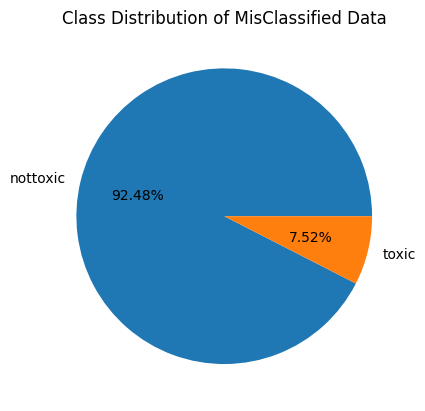

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.pie(df_misclassified["toxicity"].value_counts(), labels=['nottoxic','toxic'], autopct='%1.2f%%')
plt.title('Class Distribution of MisClassified Data')
plt.show()

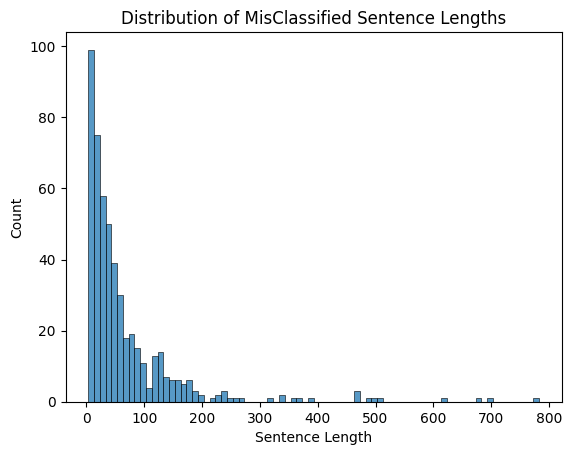

In [57]:
sentence_lengths = df_misclassified['comment'].apply(lambda x: len(x.split()))


sns.histplot(data=sentence_lengths, binwidth=10)

plt.xlabel('Sentence Length')
plt.ylabel('Count')
plt.title('Distribution of MisClassified Sentence Lengths')

plt.show()

# Test For inference Code

In [64]:
df_test = pd.read_csv(args.raw_test_dataset_csv)
def preprocess_text(text):
    text = re.sub(r"[^0-9a-zA-Z ]", "", text).lower()
    text = text.strip()
    text = re.sub(' +', ' ', text)
    return text

df_test.comment = df_test.comment.apply(preprocess_text)


In [65]:
set_seed_everywhere(args.seed, args.cuda)
classifier.load_state_dict(torch.load('./model_storage/model.pth'))
classifier = classifier.to(args.device)
classifier.eval()
def predict_toxicity(comment, classifier, vectorizer):
    vectorized_comment, vec_length = vectorizer.vectorize(comment, args.max_seq_length)
    #print(vectorized_comment, vec_length)
    vectorized_comment = torch.tensor(vectorized_comment).unsqueeze(dim=0).to(args.device)
    vec_length = torch.tensor([vec_length], dtype=torch.int64).to(args.device)

    result = classifier(vectorized_comment, vec_length, apply_sigmoid=True)
    pred_prob = result.item()
    pred = (result > 0.5).long().item()
    return pred_prob, pred

In [66]:
df_test[['probability', 'pred']] = df_test['comment'].apply(lambda x: pd.Series(predict_toxicity(x, classifier, vectorizer)))

In [75]:
submission = df_test[['probability', 'pred']]

In [76]:
submission.to_csv('./submission.csv', index=False)